In [1]:
%matplotlib inline

In [28]:
import glob
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [29]:
# Set these to be the directories containing the data subdirectories
# (so xzIntensity and OMAG BScans are 2 levels down from this dir).
TRAIN_DATA_DIR = '/Users/peilinli/Documents/fydp.nosync/optics-project/data/2015-08-11-Images-50'
TEST_DATA_DIR = '/Users/peilinli/Documents/fydp.nosync/optics-project/data/2015-09-07-Images-46'

# Shuffle buffer size (>= dataset size for perfect shuffling)
BUFFER_SIZE = 400


In [30]:
# Decodes a grayscale PNG, returns a 2D tensor.
def load_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_png(image)
    return image


In [31]:
# Returns a pair of tensors containing the given B-scan and its
# corresponding OMAG. |bscan_path| should be in directory 'xzIntensity'
# and its parent directory should contain 'OMAG Bscans'. Scan files
# should be named <num>.png (no leading 0s), with a 4-to-1 ratio of
# B-scans to OMAGs.
# (OMAG Bscans/1.png corresponds to xzIntensity/{1,2,3,4}.png.)
def get_images(bscan_path):
    bscan_img = load_image(bscan_path)
    path_components = re.search(r'^(.*)xzIntensity/(\d+)\.png$', bscan_path)
    
    dir_path = path_components.group(1)
    bscan_num = int(path_components.group(2))
    
    omag_num = ((bscan_num-1) // 4) + 1
    omag_img = load_image(os.path.join(dir_path, 'OMAG Bscans', '{}.png'.format(omag_num)))
    
    bscan_img = tf.cast(bscan_img, tf.float32)
    omag_img = tf.cast(omag_img, tf.float32)
    
    return bscan_img, omag_img


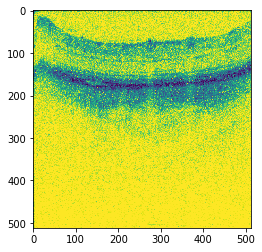

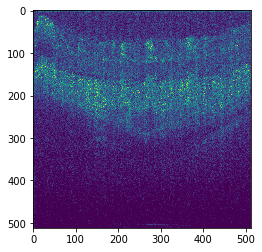

In [32]:
# Test dump input 100 from the '2015-08-11 Images50'
# dataset.

with tf.compat.v1.Session() as sess:
    input_img, output_img = get_images(os.path.join(TRAIN_DATA_DIR, 'xzIntensity', '100.png'))
    input_img = sess.run(input_img)
    output_img = sess.run(output_img)
    
plt.figure()
plt.imshow(tf.squeeze(input_img))
plt.figure()
plt.imshow(tf.squeeze(output_img))


In [33]:
# Build a tf.data.Dataset of input B-scan and output OMAG images in the given directory.
def get_dataset(data_dir):
    dataset = tf.data.Dataset.from_generator(
        lambda: map(get_images, glob.glob(os.path.join(data_dir, 'xzIntensity', '*.png'))),
        output_types=(tf.float32, tf.float32)
    )
    # silently drop data that causes errors (e.g. corresponding OMAG file doesn't exist)
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(1)
    return dataset

train_dataset = get_dataset(TRAIN_DATA_DIR)
test_dataset = get_dataset(TEST_DATA_DIR)


# pix2pix generator


In [34]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(input_img, 0))
print (down_result.shape)


(1, 256, 256, 3)


In [35]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)


(1, 512, 512, 3)


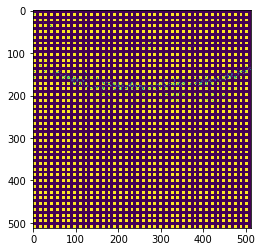

In [36]:
def Generator():
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,1])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()

gen_output = generator(input_img[tf.newaxis,...], training=False)
plt.imshow(tf.squeeze(gen_output[0,...]))


# pix2pix discriminator


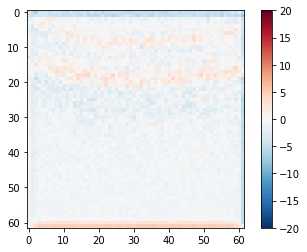

In [37]:
inp = input_img

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
